# Vector Space Semantics for Similarity between Eastenders Characters

In this project, we will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this task stipulates we can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [6]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [28]:

# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """
    Returns a dict with the name of the character as key,
    their lines, the line spoken by another character just before their line, and the next line spoken
    by another character in the same scene joined together as a single string, with end of line EOL
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    
    character_docs = {}
    character_line_count = {}
    # sort the dataframe so the the scenes are present in sorted order
    df = df.sort_values(['Episode', 'Scene']) 
    for line, name, gender, epi_scene, scene_info in zip(df.Line, df.Character_name, df.Gender, df.Scene, df.Scene_info):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        try:
            if previous_scene == epi_scene:
                character_docs[previous_name] += str(line) + ' nexteol '
                character_docs[name] += str(previous_line)+ ' previouseol ' + str(line) + " EOL "
               
        except Exception as e:
            # it will through an exception if the line is the first line as it will not have any previous information stored.            
            character_docs[name] += str(line) + " EOL " # adding an end-of-line token
        character_line_count[name]+=1
        previous_line = line
        previous_name = name
        previous_scene = epi_scene
        previous_sceneinfo = scene_info
        
    print("lines per character", character_line_count)
    return character_docs


In [8]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'ROXY': 360, 'TANYA': 360, 'SEAN': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
ROXY Number of Words:  3838
TANYA Number of Words:  3786
SEAN Number of Words:  3637
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [29]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    
    
    import re
    import nltk
    
    #print(type(character_text))
    #words = nltk.word_tokenize(character_text)
    #print(words)
    #Data cleaning and preprocessing
    
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    
    
    #stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    corpus = []
    
    
    #for i in range(0, len(character_text)):
    #print(character_text)
    
    
    clean_text = re.sub('[^a-zA-Z0-9]', ' ', character_text)  #Removing all the punctuation marks and replacing them with a space
    clean_text = re.sub(r'\s+',' ',clean_text)
    clean_text = clean_text.lower()  #lowering all the texts
    clean_text = re.sub(r'\d',' ',clean_text)    #removing digits
    clean_text = re.sub(r'\s+',' ',clean_text)  #removing unnncessary spaces
    
    clean_text = clean_text.split() #splitting to get list of words
    
    #clean_text = [stemmer.stem(word) for word in clean_text if not word in stopwords.words('english')]   #implementing stemming
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text if not word in stopwords.words('english')]    #implementing lemmatisation
    clean_text = ' '.join(clean_text)
    clean_text = clean_text.split()
    """
    #print(type(clean_text))
    #corpus.append(str(clean_text))
    """
        
    return clean_text

In [10]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [11]:
def glue_tokens(tokens, order):
    """A useful way of glueing tokens together for
    Kneser Ney smoothing and other smoothing methods
    
    :param: order is the order of the language model
        (1 = unigram, 2 = bigram, 3 =trigram etc.)
    """
    #glued_list.append({0}@{1}.format(order,''.join(tokens)))
                      
    
    
    return '{0}@{1}'.format(order,''.join(tokens))


In [12]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    
    
    """
    #Adding POS tags
    print(character_doc[0])
    pos_tags = nltk.pos_tag(character_doc)
    postag_words = [(word, tag) for word, tag in pos_tags]      
    pos_tagged_words = [str(postag_words) for postag_words in postag_words]    # convert pos_tagged words to string
    count_pos = Counter(pos_tagged_words)
    count_pos = dict(count_pos)
    counts.update(count_pos)
    print(count_pos)
    
    
    """
    """
    #Extracting bigrams from character_docs
    bigrams = nltk.bigrams(character_doc)
    bigrams = ['_'.join(bigram) for bigram in bigrams]   # appending trigrams with _ and adding it to counts
    #print(bigrams)
    counts = Counter(bigrams)
    
    """
    
    
    """
    #Extracting trigrams from character_docs
    trigrams = nltk.trigrams(character_doc)
    trigrams = ['_'.join(trigram) for trigram in trigrams]   # appending trigrams with _ and adding it to counts
    counts.update(Counter(trigrams))
    """
    
    
    # implementing sentiment analysis on character_doc
    sentiment_analyzer = SentimentIntensityAnalyzer()
    character_doc = ' '.join(character_doc)
    pol_scores = sentiment_analyzer.polarity_scores(character_doc)
    pol_scores = dict(pol_scores)
    counts.update(pol_scores)
    
    
    
    
       
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    #print("feature",feature)
    print(counts)
    return counts 


In [13]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


tfidf_transformer = TfidfTransformer()  # initialising tf-idf transformer

def create_document_matrix_from_corpus(corpus, fitting=False,labels):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    
    if fitting: 
        tfidf_transformer.fit(doc_feature_matrix)       # using tf-idf transformer to improve mean rank
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix)
    
    if fitting:
        selector = SelectKBest(score_func=chi2, k=2600)
        selector.fit(doc_feature_matrix, labels)
        doc_feature_matrix = selector.transform(doc_feature_matrix)
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

{'lesley': 3, 'really': 10, 'glad': 2, 'must': 2, 'ian': 29, 'eol': 342, 'partner': 2, 'ashley': 3, 'lovely': 2, 'little': 3, 'place': 3, 'seen': 4, 'flesh': 1, 'compare': 1, 'way': 7, 'described': 1, 'keep': 4, 'forgetting': 1, 'changed': 1, 'name': 2, 'would': 4, 'therapist': 1, 'bloke': 4, 'make': 8, 'might': 9, 'say': 10, 'indicates': 1, 'attempt': 1, 'run': 2, 'away': 4, 'something': 6, 'let': 8, 'go': 4, 'amongst': 1, 'thing': 6, 'sister': 3, 'called': 2, 'love': 8, 'hate': 2, 'relationship': 1, 'right': 6, 'jane': 19, 'much': 3, 'break': 1, 'heart': 1, 'bottle': 2, 'best': 3, 'champagne': 1, 'please': 1, 'start': 4, 'counting': 1, 'penny': 2, 'paying': 3, 'ash': 3, 'know': 14, 'exactly': 3, 'imagined': 1, 'kind': 2, 'end': 2, 'marrying': 1, 'mean': 6, 'david': 3, 'always': 4, 'going': 9, 'tough': 1, 'act': 3, 'follow': 1, 'word': 1, 'think': 11, 'found': 1, 'yeah': 20, 'well': 16, 'hampstead': 1, 'heath': 1, 'allowed': 1, 'authority': 1, 'take': 9, 'dim': 1, 'view': 1, 'probatio

In [14]:
training_feature_matrix

<16x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 10851 stored elements in Compressed Sparse Row format>

In [15]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [16]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

{'cheap': 1, 'aftershave': 1, 'think': 3, 'running': 1, 'chip': 1, 'shop': 1, 'nut': 1, 'eol': 40, 'ian': 5, 'beale': 1, 'lucky': 1, 'mine': 1, 'married': 1, 'christian': 1, 'jane': 3, 'brother': 1, 'come': 1, 'sister': 1, 'kept': 1, 'one': 2, 'quiet': 1, 'like': 3, 'grant': 1, 'gay': 2, 'bar': 1, 'know': 2, 'barmaid': 1, 'fancy': 1, 'wait': 1, 'clay': 1, 'drawing': 1, 'impurity': 1, 'male': 1, 'grooming': 1, 'around': 1, 'century': 1, 'egyptian': 1, 'men': 1, 'wore': 1, 'make': 2, 'roman': 1, 'dyed': 1, 'hair': 1, 'bath': 1, 'house': 1, 'want': 3, 'help': 1, 'wish': 1, 'continue': 1, 'walking': 1, 'earth': 1, 'dirty': 1, 'unscrubbed': 1, 'hairy': 1, 'strictly': 1, 'monochromatic': 1, 'colour': 2, 'crew': 1, 'neck': 1, 'shirt': 1, 'skinny': 1, 'jean': 1, 'might': 2, 'pushing': 1, 'born': 1, 'gaultier': 1, 'gene': 1, 'david': 1, 'beckham': 1, 'daniel': 1, 'craig': 1, 'clive': 1, 'owen': 1, 'effort': 1, 'last': 1, 'romantic': 1, 'thing': 2, 'need': 2, 'something': 2, 'today': 1, 'gesture

In [17]:
val_feature_matrix

<16x3628 sparse matrix of type '<class 'numpy.float64'>'
	with 1968 stored elements in Compressed Sparse Row format>

In [18]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [19]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [20]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [21]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.4375
mean cosine similarity 0.8668015639495774
12 correct out of 16 / accuracy: 0.75


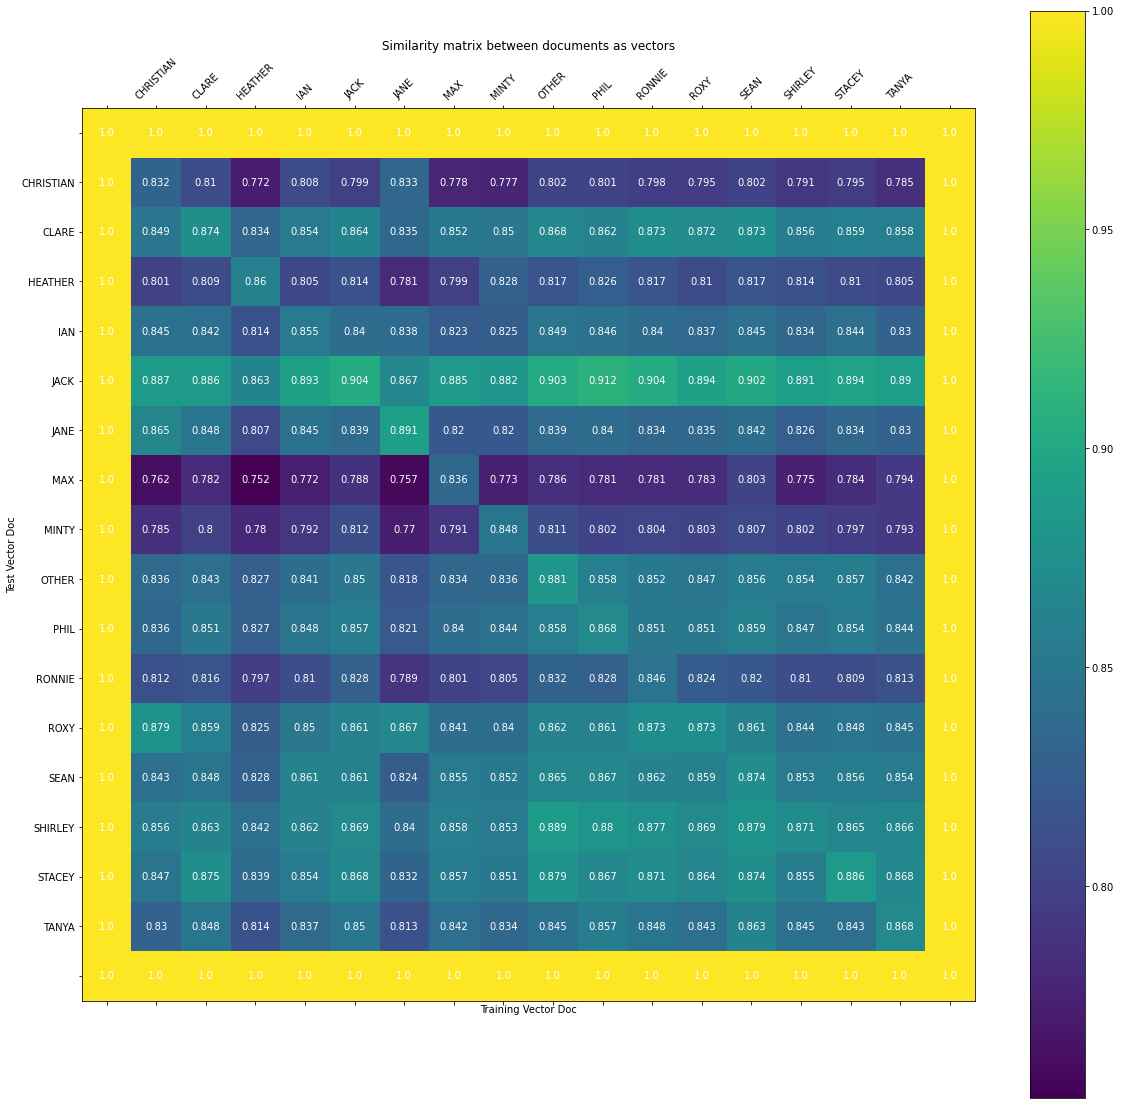

In [22]:
plot_heat_map_similarity(df)

# Improving pre-processing
Using the pre-processing techniques,we will improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric we need to focus on improving throughout this task, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- we should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


*** Initial score without implementing pre-processing ***

mean rank 4.5

mean cosine similarity 0.9128136458100018

4 correct out of 16 / accuracy: 0.25


*** Score after implementing pre-processing with stemming*** 

mean rank 3.15

mean cosine similarity 0.9227162611895239

8 correct out of 16 / accuracy: 0.50
    
*** Score after implementing pre-processing with lemmatisation*** 

mean rank 2.25

mean cosine similarity 0.9427868611895239

10 correct out of 16 / accuracy: 0.625


# Improving linguistic feature extraction
We will use some feature extraction techniques to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. We can also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

*** Score before improving feature extraction ***

mean rank 2.25
mean cosine similarity 0.9427868611895239
10 correct out of 16 / accuracy: 0.625

*** Score after adding bigrams ***

mean rank 2.4375
mean cosine similarity 0.3107899298808582
9 correct out of 16 / accuracy: 0.5625

*** Score after adding postags ***

mean rank 1.8125
mean cosine similarity 0.9162059748804816
12 correct out of 16 / accuracy: 0.75


*** Score after adding trigrams ***

mean rank 2.3125
mean cosine similarity 0.9315487243954772
9 correct out of 16 / accuracy: 0.5625

*** Score after sentiment analysis ***

mean rank 2.25
mean cosine similarity 0.9425199395605685
10 correct out of 16 / accuracy: 0.625


# Adding dialogue context data and features
Adjusting `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after).

**Score before adding any context data or preprocessing**

mean rank 4.5

mean cosine similarity 0.9128136458100018

4 correct out of 16 / accuracy: 0.25
    
**Score after adding context, preprocessing  and pos_tags**

mean rank 1.9375

mean cosine similarity 0.8583346658416517

11 correct out of 16 / accuracy: 0.6875
    
**Score after adding context, preprocessing  and bigrams**

mean rank 3.375

mean cosine similarity 0.229849863518613

8 correct out of 16 / accuracy: 0.5


**Score after adding context, preprocessing  and trigrams**

mean rank 1.9375

mean cosine similarity 0.8779396668324451

9 correct out of 16 / accuracy: 0.5625

**Score after adding context, preprocessing  and sentiment analysis**
 
mean rank 1.875

mean cosine similarity 0.891430257862406

9 correct out of 16 / accuracy: 0.5625
    


# Improving the vectorization method
Using a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

*** Score before adding any transformation methods ***

mean rank 1.875
mean cosine similarity 0.891430257862406
9 correct out of 16 / accuracy: 0.5625
    
    
*** Score after using tfidf transformer ***  

mean rank 1.5625
mean cosine similarity 0.7935734045064942
10 correct out of 16 / accuracy: 0.625    

# Select and test the best vector representation method
Finishing the optimization of our vector representations by selecting the best combination of the techniques we tried and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

In [24]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

tfidf_transformer = TfidfTransformer()  # initialising tf-idf transformer

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True,train_labels


# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False,test_labels)



lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'ROXY': 400, 'TANYA': 400, 'SEAN': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
ROXY Number of Words:  4200
TANYA Number of Words:  4214
SEAN Number of Words:  4026
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
{'look': 24, 'ya': 11, 'mark': 1, 'think': 14, 'unlucky': 1, 'man': 3, 'eol': 400, 'gonna': 19, 'get': 24, 'help': 7, 'oh': 14, 'phone': 2, 'kevin': 13, 'smashed': 1, 'ssh': 1, 'shut': 6, 'fire': 1, 'brigade': 1, 'ambulance': 2, 'accident': 2, 'ind

In [25]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.0625
mean cosine similarity 0.863560700462623
15 correct out of 16 / accuracy: 0.9375


<ipython-input-20-89ca39ec0276>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:


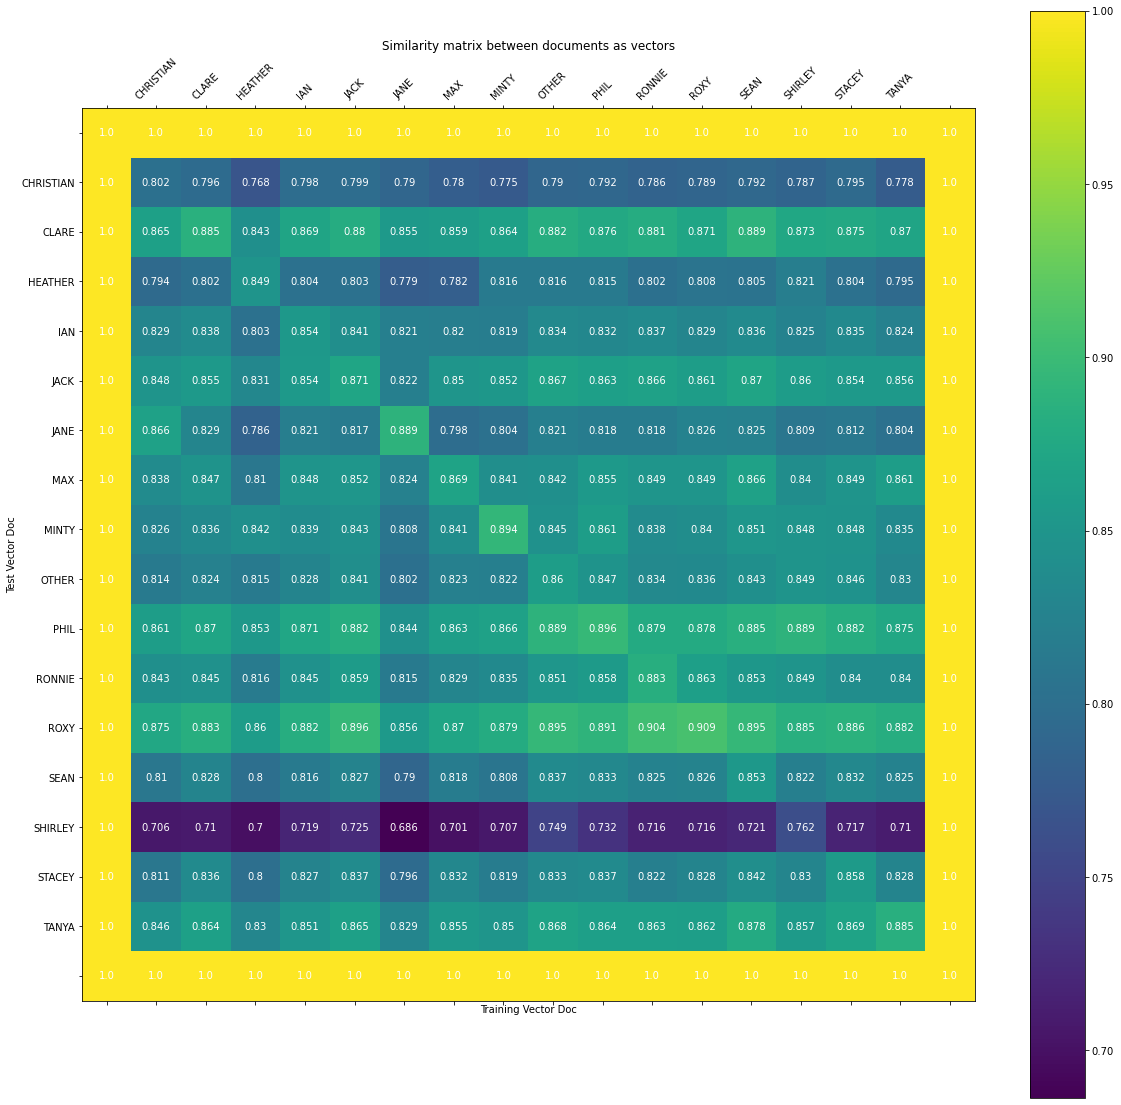

In [26]:
plot_heat_map_similarity(df)